In [ ]:
#importing necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import seaborn as sns 
plt.style.use('fivethirtyeight')
import os 
import numpy as np
import cv2 
%matplotlib inline
import skimage
from skimage import io, img_as_float 
from skimage.filters import gaussian, median
from skimage.morphology import disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA PREPROCESSING

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                img_median = median(resized_arr, disk(3), mode = 'constant', cval= 0.0)
                data.append([img_median, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_training_data('/content/drive/MyDrive/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


In [ ]:
#train
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('people with Pneumonia in train set:', pnenumonia)
print('people without Pneumonia in train set:', normal)

people with Pneumonia in train set: 3875
people without Pneumonia in train set: 1341


In [ ]:
#test
pnenumonia = 0 
normal = 0 

for i, j in test:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('people with Pneumonia in test set:', pnenumonia)
print('people without Pneumonia in test set:', normal)

people with Pneumonia in test set: 390
people without Pneumonia in test set: 234


In [ ]:
#validation
pnenumonia = 0 
normal = 0 

for i, j in val:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('people with Pneumonia in validation set:', pnenumonia)
print('people without Pneumonia in validation set:', normal)

people with Pneumonia in validation set: 8
people without Pneumonia in validation set: 8


PNEUMONIA


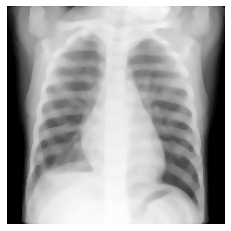

In [ ]:
plt.imshow(train[10][0],cmap='gray')
plt.axis('off')
print(labels[0])

NORMAL


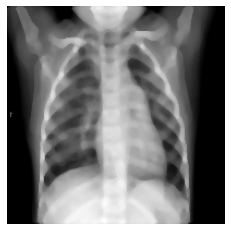

In [ ]:
plt.imshow(train[5000][0],cmap='gray')
plt.axis('off')
print(labels[1])

In [ ]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)
# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

# CNN MODEL

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [ ]:
history = model.fit(X_train, y_train, batch_size=10, callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 1921s 5s/step - loss: 0.4409 - acc: 0.8038 - val_loss: 0.2216 - val_acc: 0.9221
Epoch 2/15
375/375 [==============================] - 1883s 5s/step - loss: 0.2507 - acc: 0.8948 - val_loss: 0.1695 - val_acc: 0.9381
Epoch 3/15
375/375 [==============================] - 1899s 5s/step - loss: 0.2278 - acc: 0.9082 - val_loss: 0.1945 - val_acc: 0.9264
Epoch 4/15
375/375 [==============================] - 1920s 5s/step - loss: 0.2056 - acc: 0.9213 - val_loss: 0.1643 - val_acc: 0.9434
Epoch 5/15
375/375 [==============================] - 1891s 5s/step - loss: 0.1895 - acc: 0.9263 - val_loss: 0.1561 - val_acc: 0.9402
Epoch 6/15
375/375 [==============================] - 1874s 5s/step - loss: 0.1599 - acc: 0.9378 - val_loss: 0.1559 - val_acc: 0.9424
Epoch 7/15
375/375 [==============================] - 1872s 5s/step - loss: 0.1494 - acc: 0.9421 - val_loss: 0.1654 - val_acc: 0.9424
Epoch 8/15
375/375 [==============================] - 1855s 5s

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 152s 4s/step - loss: 0.1250 - acc: 0.9573


[0.12501731514930725, 0.9573378562927246]

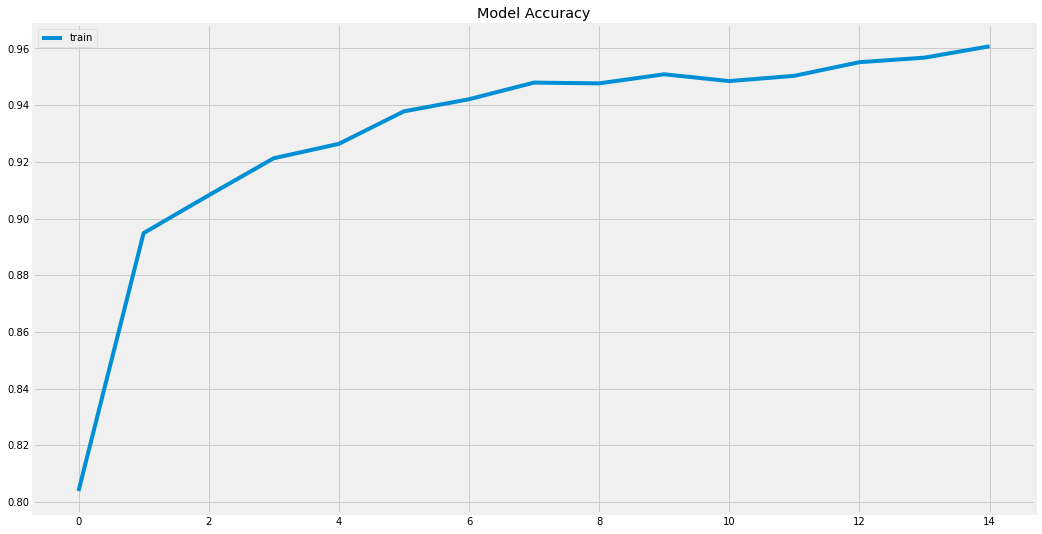

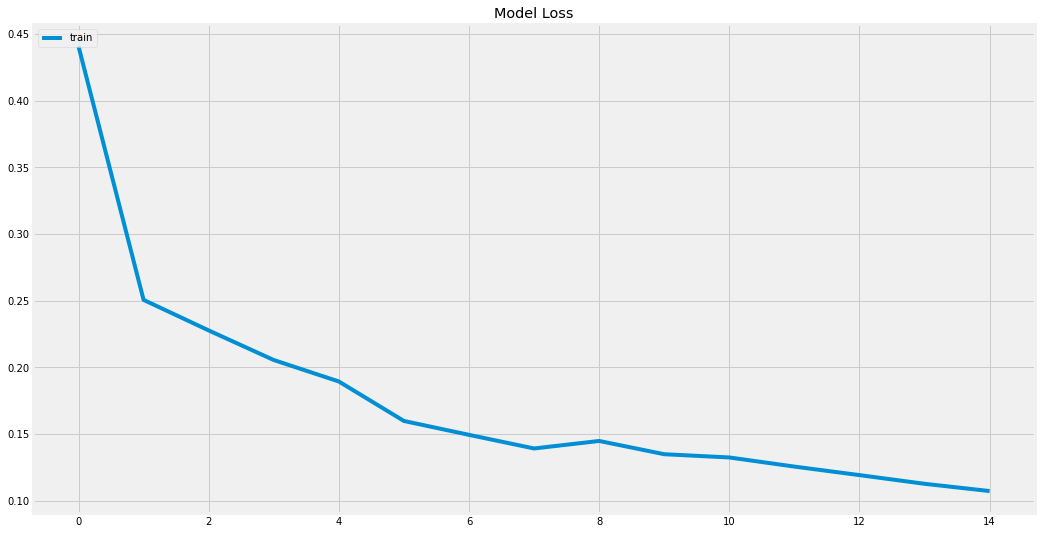

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
pred
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9129692832764505
Precision on testing set: 0.9878419452887538
Recall on testing set: 0.7683215130023641


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

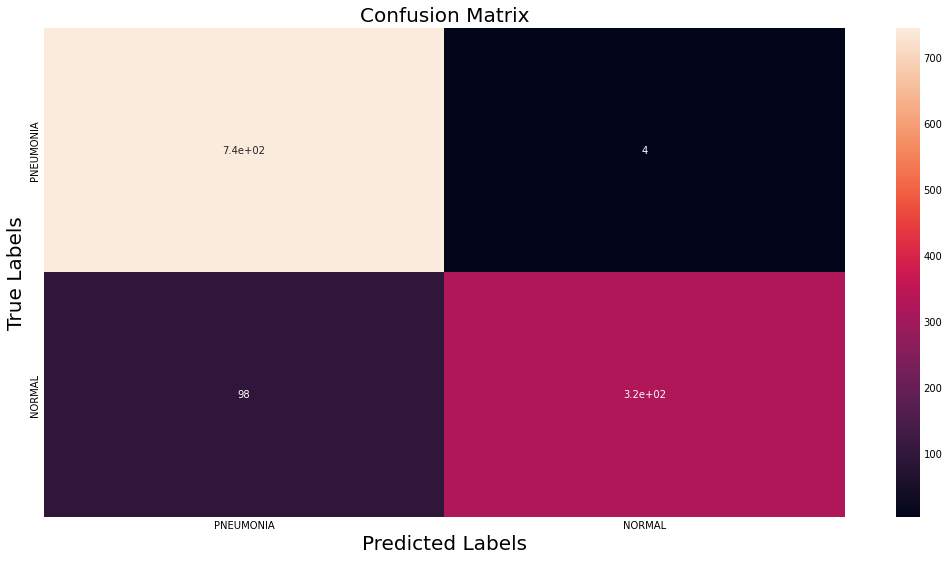

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# FINAL RESULT

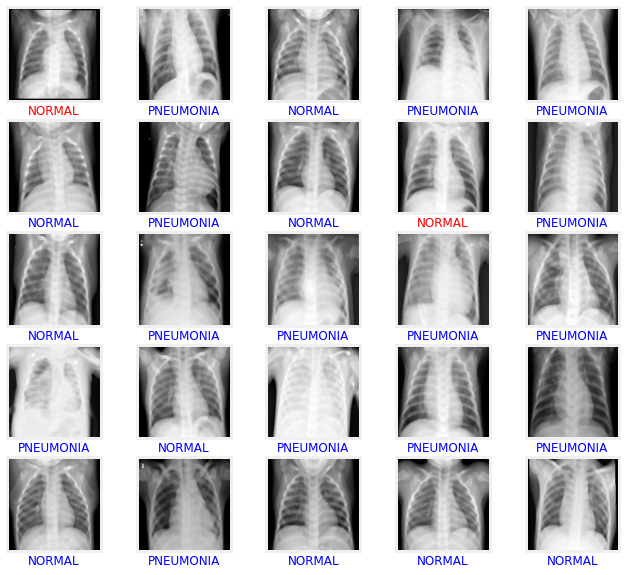

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()